## Problem Definition:
#####  As there is a lot of active research going on image/video generation and manipulation, that helps to evolve many new ways to manipulate the original sources at the same time this leads to a loss of trust in digital content, but it might even cause further harm by spreading false information and the creation of fake news. 

## Objective

#### We need to build a model such that it should recognize whether the given video(or  image sequence) is  fake or real. 

## Data Gathering

#### 1. I have downloaded total of 800  videos (200 original+600 manipulated) 




In [ ]:
!python Download_Script.py /content/FF++ -d Face2Face -c c23 -t videos -n 200
!python Download_Script.py /content/FF++ -d Deepfakes -c c23 -t videos -n 200
!python Download_Script.py /content/FF++ -d FaceSwap -c c23 -t videos -n 200
!python Download_Script.py /content/FF++ -d original -c c23 -t videos -n 200

2. For each video each folder is created with the same name and placed the extracted images in these repective folders 

In [ ]:
!python extract_compressed_videos.py --data_path /content/FF++ -c c23

In [ ]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

In [ ]:
DATASET_PATHS = {
    'original': '/content/gdrive/MyDrive/ffmg/original_sequences/youtube',
    'Deepfakes': '/content/gdrive/MyDrive/ffmg/manipulated_sequences/Deepfakes',
    'Face2Face': '/content/gdrive/MyDrive/ffmg/manipulated_sequences/Face2Face',
    'FaceSwap': '/content/gdrive/MyDrive/ffmg/manipulated_sequences/FaceSwap',
}

### Lets observe extracted images form each type

In [ ]:
images = []
for path in DATASET_PATHS:
    for seq in os.listdir(DATASET_PATHS[path]+'/c23/images/')[:1]:
        for image in os.listdir(DATASET_PATHS[path]+'/c23/images/'+seq)[:1]:
            img = cv2.imread(DATASET_PATHS[path]+'/c23/images/'+seq+'/'+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append([img,path])
         

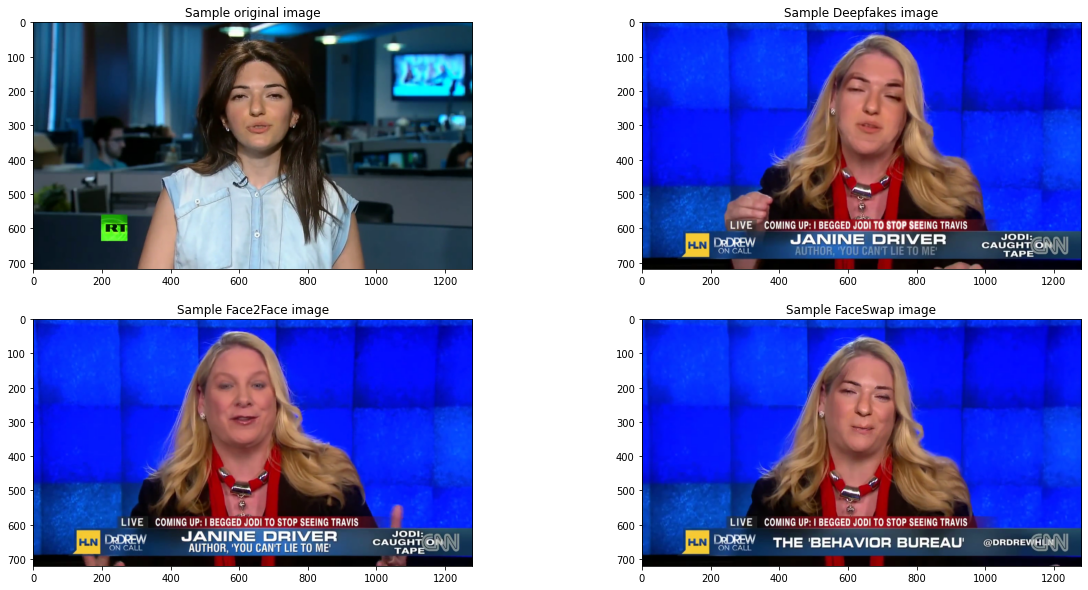

In [ ]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Sample {} image".format(images[i][1]))
    plt.imshow(images[i][0])

### We are only interested in face part, Hence tracking only faces in the images 

In [ ]:
import os
import argparse
from os.path import join
import cv2
import dlib
import torch
import torch.nn as nn
from PIL import Image as pil_image
from tqdm import tqdm

def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    """
    Expects a dlib face to generate a quadratic bounding box.
    :param face: dlib face class
    :param width: frame width
    :param height: frame height
    :param scale: bounding box size multiplier to get a bigger face region
    :param minsize: set minimum bounding box size
    :return: x, y, bounding_box_size in opencv form
    """
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

In [ ]:
face_detector = dlib.get_frontal_face_detector()
cropped_face =[]
for image in images:
    faces = face_detector(image[0], 1)
    height, width = image[0].shape[:2]
    try: # If in case face is not detected at any frame 
        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
    except IndexError:
        continue
    cropped_face.append([image[0][y:y+size, x:x+size],image[1]])

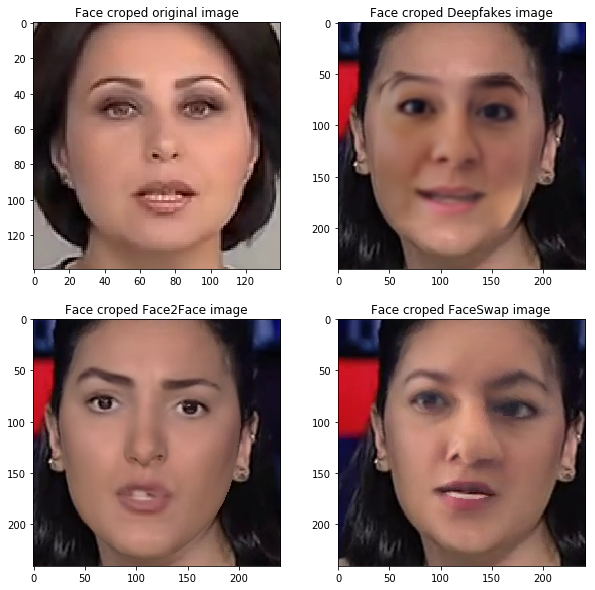

In [ ]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Face croped {} image".format(cropped_face[i][1]))
    plt.imshow(cropped_face[i][0])

#### We repeat the same process for every image , before that lets split the data into Train, Cv, Test 

## Data Splitting

#### split the data into 60% train(120real,120DF,120FS,120F2F)=480vid , 30% test(60real,60DF,60FS,60F2F)=240vid ,
#### 10% val(20real,20DF,20FS,20F2F)=80vid


#### Train - Test split
    Data
      |--Train
          |--Real (120 videos)
          |--Fake (120,120,120) =====> (120 Deepfakes, 120 FaceSwap, 120 Face2Face)
      |--Test
          |--Real (60)
          |--Fake (60,60,60)      
      |--Cv
          |--Real (20)
          |--Fake (20,20,20)


### Creating Train, Test, CV split lists

In [ ]:
train_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[:119]  ## first 120 vid for train
train_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[:119]
train_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[:119]
train_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[:119]
train = [train_original,train_Deepfakes,train_FaceSwap,train_Face2Face]
types = ['original','Deepfakes','FaceSwap','Face2Face']

In [ ]:
test_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[120:179] ## second 60 vid for test
test_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[120:179]
test_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[120:179]
test_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[120:179]
test = [test_original,test_Deepfakes,test_FaceSwap,test_Face2Face]

In [ ]:
cv_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[180:] ## third 20 vid for val
cv_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[180:]
cv_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[180:]
cv_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[180:]
cv = [cv_original,cv_Deepfakes,cv_FaceSwap,cv_Face2Face]

#### As there is a large sequnece in each video, tracking face in every image may increase the data redendancy also the data need more balancing between real and fake , hence the idea is to track the face only in 150 frame from each real videos and 50 frame from each F2F,DF,FS video 




In [ ]:
def track_face(split_type,Split,output_mkdir=True):
    """
    Expects a splited data list and generates face tracked images if real only 150 frame if fake only 50x3 fram=150 fake.
    :split_type: list video names for train/test/cv
    :Split: train/test/cv in str format
    This function will generate face tracked images for train/test/cv data
    and will place the same in corresponding directory 
    """
    
    for part in zip(split_type,types):
        for video in tqdm(part[0]):
            if output_mkdir==True:
                os.makedirs('Data/'+Split+'/'+part[1]+'/'+video, exist_ok=True)
            input_path = DATASET_PATHS[part[1]]+'/c23/images/'+video
            output_path = 'Data/'+Split+'/'+part[1]+'/'+video
            images = os.listdir(input_path)
            images.sort(key=lambda x: os.path.getmtime(input_path+'/'+x))

            
            if part[1]=='original':
                for img in images[10:160]: #Taking 150  frames from each Real video starts form fram num 10 till FNm 160 for Data balance and redandancy
                    image = cv2.imread(input_path+'/'+img)
                    faces = face_detector(image, 1)
                    height, width = image.shape[:2]
                    try: # If in case face is not detected at any frame 
                        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                    except IndexError:
                        continue
                    cropped_face = image[y:y+size, x:x+size]
                    cv2.imwrite(output_path+'/'+img,cropped_face) 
            else:
                 for img in images[10:60]:#Taking 50  frames from each Fake video start form fram num 10 till FNm 60 for Data balance 
                    image = cv2.imread(input_path+'/'+img)
                    faces = face_detector(image, 1)
                    height, width = image.shape[:2]
                    try: # If in case face is not detected at any frame 
                        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                    except IndexError:
                        continue
                    cropped_face = image[y:y+size, x:x+size]
                    cv2.imwrite(output_path+'/'+img,cropped_face) 


#### Finally the dataset will be extracted to faces images and having the following structure:
#### 200 real vid X 150 frame = 30,000 real face img
### 600 fake vid X 50 frame = 30,000 fake face img  

#### split train dataset into 120 real vid X 150 fpv + 120 X 3 fake vid X 50 fpv = 18,0000 real face img + 18,0000 fake face img

In [ ]:
track_face(split_type=train,Split='train')

#### split test dataset into 60 real vid X 150 fpv + 60 X 3 fake vid X 50 fpv = 9,0000 real face img + 9,0000 fake face img

In [ ]:
track_face(split_type=test,Split='test')

#### split val dataset into 20 real vid X 150 fpv + 20 X 3 fake vid X 50 fpv = 3,0000 real face img + 3,0000 fake face img

In [ ]:
track_face(split_type=cv,Split='cv')

### Checking some of the face tracked images in each split and category

In [ ]:
def show_samples(split_name, category):
    """
    Expects a split type ("test"/"train"/"cv") and categoty (video type)
    and displays the 1st 20 face tracked images for a given
    split_name and category
    example : 
    show_samples(split_name="train", category="original")
    """
    category_ =[category]
    if split_name=='cv':
        videos= cv[types.index(category)][0]
    else:
        videos = [train[types.index(cat)] if split_name=='train' else test[types.index(cat)] for cat in category_][0][2]
    plt.figure(figsize=(10,10))
    for video in [videos]:
        frames=os.listdir('Data/'+split_name+'/'+category+'/'+video) 
        j=0
        seq = os.listdir('Data/'+split_name+'/'+category+'/'+video)
        seq.sort(key=lambda x: os.path.getmtime('Data/'+split_name+'/'+category+'/'+video+'/'+x))
        for i,image in enumerate(seq):     
            if j==20:
                break
            plt.subplot(4,5,1+i)
            img = cv2.imread('Data/'+split_name+'/'+category+'/'+video+'/'+'/'+image)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            j = j+1
        break
    plt.show()

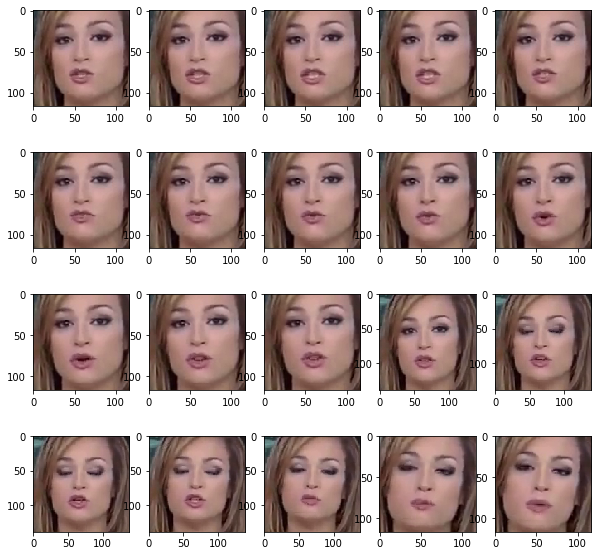

In [ ]:
show_samples(split_name="train", category='original')

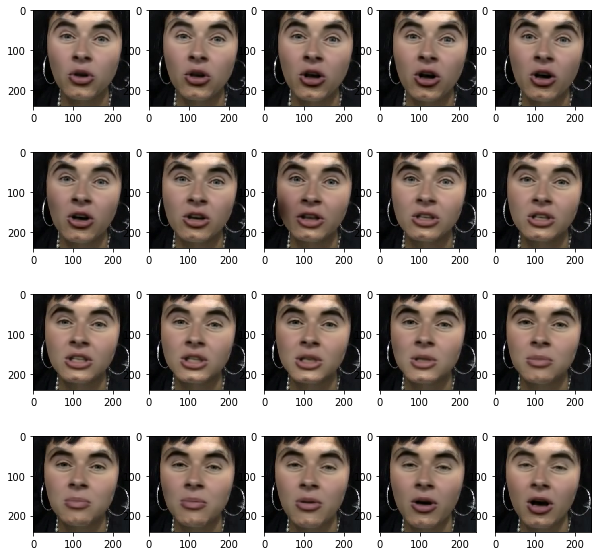

In [ ]:
show_samples(split_name="cv", category='Deepfakes')

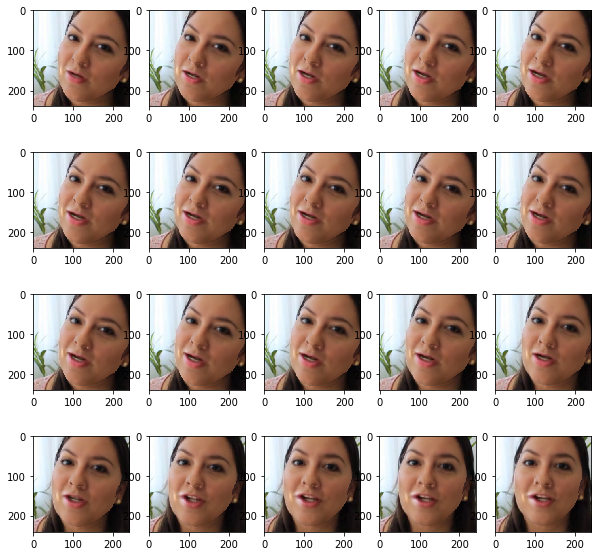

In [ ]:
show_samples(split_name="test", category='Face2Face')

### Data Preprocessing and storing

1. Shuffle the videos 
2. Read the face cropped images 
3. Assigning class label to every image 1 or 0 (Fake =1 and Real =0)
4. Preprocessing the data and creat txt files contains video paths and lablels to perform the train

In [ ]:
#Created to shuffle the videos
train_=[]
for ind,i in enumerate(train):
    for j in i:
        train_.append(j+'_'+types[ind])
test_=[]
for ind,i in enumerate(test):
    for j in i:
        test_.append(j+'_'+types[ind])
        
cv_=[]
for ind,i in enumerate(cv):
    for j in i:
        cv_.append(j+'_'+types[ind])

In [ ]:
TRAIN_DATADIR = "Data/train"
TEST_DATADIR = "Data/test"
CV_DATADIR = 'Data/cv'
#CLASSES = ["original", "Deepfakes","FaceSwap","Face2Face"]

In [ ]:
def csv_data(DATADIR,shuffled_list):
    """
    Expects Data Directory and suffled videos list
    and will returns list of image arrays and its class label (1 or 0)
    return X,y => image_arrays, class_labels
    """
    csv = []
    for name in shuffled_list: 
        label = name.split('_')[-1] 
        class_num = 0
        folder_name = name.split('_')[0]
        #seq = os.listdir(DATADIR+'/'+name.split('_')[-1])
        if len(name.split('_'))==3:
            class_num=1
            folder_name = name.split('_')[0]+'_'+name.split('_')[1]
        files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
        path = DATADIR+'/'+label+'/'+folder_name
        files.sort(key=lambda x: os.path.getmtime(DATADIR+'/'+label+'/'+folder_name+'/'+x))     
        for img in files:           
            try:
                csv.append(str(os.path.join(path,img))+' '+str(class_num))
            except Exception as e:
                print(str(e))
            
    return csv

In [ ]:
np.random.shuffle(train_)
train_csv = csv_data(DATADIR=TRAIN_DATADIR,shuffled_list=train_)
trainfile = open("/content/train.txt","w")
for i in train_csv:
  trainfile.write(i+"\n")
trainfile.close



In [ ]:
np.random.shuffle(test_)
test_csv = csv_data(DATADIR=TEST_DATADIR,shuffled_list=test_)
testfile = open("/content/test.txt","w")
for i in test_csv:
  trainfile.write(i+"\n")
trainfile.close

In [ ]:

np.random.shuffle(cv_)
cv_csv = csv_data(DATADIR=CV_DATADIR,shuffled_list=cv_)
testfile = open("/content/val.txt","w")
for i in test_csv:
  trainfile.write(i+"\n")
trainfile.close